# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
!pip install nltk

In [2]:
# import libraries
import nltk
import numpy as np
nltk.download(['punkt', 'wordnet'])
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sqlalchemy import create_engine
import re
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Convert the Label columns to categorical 

Using the pandas get_dummies() function to convert the label columns to categorical. 

In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterDatabase.db')
df = pd.read_sql_table('Disaster', con=engine)
X = df['message']
Y = df[df.columns[5:]]
added = pd.get_dummies(df[['related','genre']])
y = pd.concat([Y, added], axis=1)

In [4]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Visualizing the text data individually we get ..

In [12]:
X.head()

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

In [13]:
y.head()

,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,...,storm,fire,earthquake,cold,other_weather,direct_report,related,genre_direct,genre_news,genre_social
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


We can see the distribution of tweets across all categories. However, since each tweet has more than one category labels there is overlap in the number of tweets per label.

In [14]:
y.sum()

request                    4513
offer                       121
aid_related               10954
medical_help               2099
medical_products           1319
search_and_rescue           725
security                    471
military                    863
child_alone                   0
water                      1684
food                       2956
shelter                    2342
clothing                    410
money                       606
missing_people              301
refugees                    880
death                      1204
other_aid                  3464
infrastructure_related     1709
transport                  1212
buildings                  1345
electricity                 538
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1155
weather_related            7343
floods                     2177
storm                      2464
fire                        282
earthqua

In [15]:
X.shape

(26386,)

Plotting the length of tweets we can see that majority of the tweets are ranging between 50-350 words. 

In [40]:
word_counts = pd.Series([len(item) for item in X]).value_counts()
word_counts = dict(sorted(word_counts.items()))
counts = word_counts.copy()
for key, value in counts.items():
      if value <= 10:
        del word_counts[key]

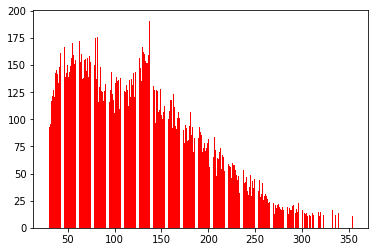

<Figure size 576x576 with 0 Axes>

In [41]:
plt.bar(word_counts.keys(), word_counts.values(), color='red')
plt.figure(figsize=(8,8))
plt.show()

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    #Remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    #Lemmatize 
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_token = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_token)
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
multioutputclf = MultiOutputClassifier(RandomForestClassifier())
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', multioutputclf)
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [8]:
def get_results(y_test, y_pred):
    rows = []
    num = 0
    for cat in y_test.columns:
        precision, recall, f_score, support = precision_recall_fscore_support(y_test[cat], y_pred[:,num], average='weighted')
        rows.append((cat, f_score, precision, recall))
        num += 1
    results = pd.DataFrame(rows, columns=['Category', 'f_score', 'precision', 'recall'])
    print('Aggregated f_score:', results['f_score'].mean())
    print('Aggregated precision:', results['precision'].mean())
    print('Aggregated recall:', results['recall'].mean())
    return results

In [9]:
results = get_results(y_test, y_pred)
results

Aggregated f_score: 0.9365444461871545
Aggregated precision: 0.9412079382778514
Aggregated recall: 0.948830665065317


c:\users\dell\anaconda3\envs\aiproject\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,f_score,precision,recall
0,request,0.874612,0.890389,0.890859
1,offer,0.993099,0.995323,0.995301
2,aid_related,0.771657,0.778429,0.776717
3,medical_help,0.900162,0.913101,0.928755
4,medical_products,0.929207,0.940958,0.950129
5,search_and_rescue,0.959269,0.965860,0.971957
6,security,0.972339,0.969413,0.981204
7,military,0.953783,0.962214,0.968167
8,child_alone,1.000000,1.000000,1.000000
9,water,0.940814,0.952478,0.952706


### 6. Improve your model
Use grid search to find better parameters. 

In [10]:
parameters = {'clf__estimator__max_depth': [10, 50, None],
              'clf__estimator__min_samples_leaf':[2, 5, 10]}
cv = GridSearchCV(pipeline, parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
results2 = get_results(y_test, y_pred)
results2

In [ ]:
cv.best_estimator_

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
# testing a pure decision tree classifier
moc = MultiOutputClassifier(DecisionTreeClassifier())

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', moc)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline.fit(X_train.as_matrix(), y_train.as_matrix())
y_pred = pipeline.predict(X_test)
results = get_results(y_test, y_pred)
results

### 9. Export your model as a pickle file

In [ ]:
pickle.dump(cv, open('model.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.